# Absolute and Weighted Frequency of Words in Text
## ...and whether or not love conquers all!

An important set of metrics in text mining, relates to the frequency of words (or any token), in a certain corpus of text documents.  
There can be an additional set of metrics in the cases where each document has an associated numeric value describing a certain attribute of the document. 

Some examples:  
* Tweets and their respective number of engagements.
* URLs and their pageviews and bounces.
* Movie titles and their gross revenue. 
* Keywords and their impressions, clicks, and conversions.

We will go through the process of creating a simple function that calculates and compares the absolute and weighted occurrence of words in a corpus of documents. This can sometimes uncover hidden trends and aggregates that aren't necessarily clear by looking at the top ten or so values. They can often be different from the absolute word frequency as well.  

Then we will see a real-life data set (movie titles and the gross revenue), and hope to discover hidden trends (love comes up somehow!)

We will be using Python as a programming language, and utilize the `collections` module's `defaultdict` data structure for the heavy lifting, as well as `pandas.DataFrame`s to manage the final output.  

Assume you have two tweets, and that their content and number of impressions (views) are as follows: 

Tweet Text | Views
----------|--------
Spain| 800
France| 200


It is simple to do the basic analysis and find out that our words are split 50:50 between 'France' and 'Spain'. In many cases, this is all you have, and you can only measure the absolute frequency of words, and try to infer certain relationships. In this case we have some data about each of the documents.  
The weighted frequency here, is clearly different, and the split is 80:20. 

> **In other words, although Spain and France both appeared once each in your tweets, from your readers' perspective, Spain appeared 800 times, while France appeared 200 times. Big difference.**

A slightly more involved example for a similar set of documents: 

Document | Views
----------|--------
france| 200
spain| 180
spain beaches| 170
france beaches| 160
spain best beaches| 160

**Simple word frequency using `defaultdict`:**

We now loop through the documents, split them into words, and count the occurrences of each of the words.

In [2]:
from collections import defaultdict

import pandas as pd

text_list = ['france', 'spain', 'spain beaches', 'france beaches', 'spain best beaches']

word_freq = defaultdict(int)

for text in text_list:
    for word in text.split():
        word_freq[word] += 1
    
(pd.DataFrame.from_dict(word_freq, orient='index')
 .sort_values(0, ascending=False)
 .rename(columns={0: 'abs_freq'}))

,abs_freq
spain,3
beaches,3
france,2
best,1


Although the top word was 'france' in the first table, after counting all the words within each document we can see that 'spain' and 'beaches' are tied for the first position.  
This is important in uncovering hidden trends, especially when the list of documents you are dealing with, is in the tens, or hundreds,  of thousands. 

**How it works:**

In the loop above, the first line loops through `text_list` one by one.  
The second line (within each document) loops through the words of each item, split by the space character (which could have been any other character ('-', ',', '\_', etc.)).  
When we try to assign a value to `word_freq[word]` there are two possible scenarios: 
1. The key `word` exists: in which case the assignment is done (adding one)
2. The key `word` is not in `word_freq`,  in this case `defaultdict` calls the default function that it was assigned to when it was first defined, which is `int` in this case.  
When `int` is called it returns zero. Now the key exists, its value is zero, and it is ready to get assigned an additional 1 to its value. 


**Adding the weighted frequency to the function:**

Now that we have counted the occurences of each word in the corpus of documents, we want to see the weighted frequency (how many times they appeared to our readers, compared to how many times we used them).  
In the first table, the absolute frequency of the words was split evenly between 'spain' and 'france', but 'spain' had clearly much more weight, because its value was 800, vs 200 or 'france'.  
Let's see if there are such differences in the second table.

`text_list` | `num_list`
----------|--------
france| 200
spain| 180
spain beaches| 170
france beaches| 160
spain best beaches| 160


In [3]:
# the old code just as a reminder: 
text_list = ['france', 'spain', 'spain beaches', 'france beaches', 'spain best beaches']
num_list = [200, 180, 170, 160, 160]

word_freq = defaultdict(int)

for text in text_list:
    for word in text.split(' '):
        word_freq[word] += 1


New code with some additions:

In [6]:
word_freq = defaultdict(lambda: [0, 0]) # default value is now a list with two ints


for text, num in zip(text_list, num_list): # looping is now over both the text and the numbers
    for word in text.split(): 
        word_freq[word][0] += 1 # same as before
        word_freq[word][1] += num # new line, incrementing the numeric value for each word

columns = {0: 'abs_freq', 1: 'wtd_freq'}
        
abs_wtd_df = (pd.DataFrame.from_dict(word_freq, orient='index')
             .rename(columns=columns )
             .sort_values('wtd_freq', ascending=False)
             .assign(rel_value=lambda df: df['wtd_freq'] / df['abs_freq']).round())
abs_wtd_df.style.background_gradient(low=0, high=.7, subset=['rel_value'])

,abs_freq,wtd_freq,rel_value
spain,3,510,170
beaches,3,490,163
france,2,360,180
best,1,160,160


**Some observations:**

* Although 'france' was the highest phrase overall, 'spain' and 'beaches' seem to be more prominent when we take the weighted frequency. 
* `rel_value` is a simple division to get the value per occurrence of each word. 
* Looking at `rel_value`, we also see that although 'france' is quite low on the `wtd_freq` metric, there seems to be potential in it, because the value per occurence is high. This might hint at increasing your content coverage of 'france' for example.

I also like to add some other metrics that show the percentages and cumulative percenatages of each type of frequency, to get a better perspective on how many words form the bulk of the total, if any. 

In [7]:
abs_wtd_df.insert(1, 'abs_perc', value=abs_wtd_df['abs_freq'] / abs_wtd_df['abs_freq'].sum())
abs_wtd_df.insert(2, 'abs_perc_cum', abs_wtd_df['abs_perc'].cumsum())
abs_wtd_df.insert(4, 'wtd_freq_perc', abs_wtd_df['wtd_freq'] / abs_wtd_df['wtd_freq'].sum())
abs_wtd_df.insert(5, 'wtd_freq_perc_cum', abs_wtd_df['wtd_freq_perc'].cumsum())
abs_wtd_df.style.background_gradient(low=0, high=0.8)

,abs_freq,abs_perc,abs_perc_cum,wtd_freq,wtd_freq_perc,wtd_freq_perc_cum,rel_value
spain,3,0.333333,0.333333,510,0.335526,0.335526,170
beaches,3,0.333333,0.666667,490,0.322368,0.657895,163
france,2,0.222222,0.888889,360,0.236842,0.894737,180
best,1,0.111111,1,160,0.105263,1,160


More can be analyzed, and with more data you would typically get more surprises. 

So how might this look in a real-world setting with some real data?  
We will take a look at movie titles, see which words are most used in the titles (absolute frequency), and which words are associated with the most revenue (weighted frequency).  
[Boxoffice Mojo](http://www.boxofficemojo.com/alltime/domestic.htm) has a list of more than 15,000 movies, together with their associated gross revenue and ranks.

We start by scraping the data using `requests` and `BeautifulSoup`:

In [9]:
import requests
from bs4 import BeautifulSoup

In [10]:
final_list = []
for i in range(1, 155):
    page = 'http://www.boxofficemojo.com/alltime/domestic.htm?page=' + str(i) + '&p=.htm'
    resp = requests.get(page)
    soup = BeautifulSoup(resp.text, 'lxml')
    table_data = [x.text for x in soup.select('tr td')[11:511]]  # trial and error to get the exact positions
    temp_list = [table_data[i:i+5] for i in range(0, len(table_data[:-4]), 5)] # put every 5 values in a row
    for temp in temp_list:
        final_list.append(temp)

In [11]:
boxoffice_df = pd.DataFrame.from_records(final_list)
boxoffice_df.head(10)

,0,1,2,3,4
0,1,Star Wars: The Force Awakens,BV,"$936,662,225",2015
1,2,Avatar,Fox,"$760,507,625",2009^
2,3,Titanic,Par.,"$659,363,944",1997^
3,4,Jurassic World,Uni.,"$652,270,625",2015
4,5,Marvel's The Avengers,BV,"$623,357,910",2012
5,6,Star Wars: The Last Jedi,BV,"$610,725,821",2017
6,7,The Dark Knight,WB,"$534,858,444",2008^
7,8,Rogue One: A Star Wars Story,BV,"$532,177,324",2016
8,9,Beauty and the Beast (2017),BV,"$504,014,165",2017
9,10,Finding Dory,BV,"$486,295,561",2016


You will see that some numeric values have some special characters, ('$', `,` , and '^'), and some values are actually 'n/a'. So we need to change those:

In [12]:
na_year_idx =  [i for i, x in enumerate(final_list) if x[4] == 'n/a'] # get the indexes of the 'n/a' values
new_years = [1998, 1999, 1960, 1973]  # got them by checking online

print(*[(i, x) for i, x in enumerate(final_list) if i in na_year_idx], sep='\n')
print('new year values:', new_years)

(7942, ['7943', 'Warner Bros. 75th Anniversary Film Festival', 'WB', '$741,855', 'n/a'])
(8083, ['8084', 'Hum Aapke Dil Mein Rahte Hain', 'Eros', '$668,678', 'n/a'])
(8133, ['8134', 'Purple Moon (Re-issue)', 'Mira.', '$640,945', 'n/a'])
(10374, ['10375', 'Amarcord', 'Jan.', '$126,250', 'n/a'])
new year values: [1998, 1999, 1960, 1973]


In [13]:
for na_year, new_year in zip(na_year_idx, new_years):
    final_list[na_year][4] = new_year
    print(final_list[na_year], new_year)

['7943', 'Warner Bros. 75th Anniversary Film Festival', 'WB', '$741,855', 1998] 1998
['8084', 'Hum Aapke Dil Mein Rahte Hain', 'Eros', '$668,678', 1999] 1999
['8134', 'Purple Moon (Re-issue)', 'Mira.', '$640,945', 1960] 1960
['10375', 'Amarcord', 'Jan.', '$126,250', 1973] 1973


Now we turn the list into a `pandas.DataFrame` by naming the columns with the appropriate names, and converting to the data types that we want. 

In [14]:
import re
regex = '|'.join(['\$', ',', '\^'])

columns = ['rank', 'title', 'studio', 'lifetime_gross', 'year']

boxoffice_df = pd.DataFrame({
    'rank': [int(x[0]) for x in final_list],  # convert ranks to integers
    'title': [x[1] for x in final_list],  # get titles as is
    'studio': [x[2] for x in final_list],  # get studio names as is
    'lifetime_gross': [int(re.sub(regex, '', x[3])) for x in final_list],  # remove special characters and convert to integer
    'year': [int(re.sub(regex, '', str(x[4]))) for x in final_list],  # remove special characters and convert to integer
})
print('rows:', boxoffice_df.shape[0])
print('columns:', boxoffice_df.shape[1])
print('\ndata types:')
print(boxoffice_df.dtypes)
boxoffice_df.head(15)

rows: 15323
columns: 5

data types:
lifetime_gross     int64
rank               int64
studio            object
title             object
year               int64
dtype: object


,lifetime_gross,rank,studio,title,year
0,936662225,1,BV,Star Wars: The Force Awakens,2015
1,760507625,2,Fox,Avatar,2009
2,659363944,3,Par.,Titanic,1997
3,652270625,4,Uni.,Jurassic World,2015
4,623357910,5,BV,Marvel's The Avengers,2012
5,610725821,6,BV,Star Wars: The Last Jedi,2017
6,534858444,7,WB,The Dark Knight,2008
7,532177324,8,BV,Rogue One: A Star Wars Story,2016
8,504014165,9,BV,Beauty and the Beast (2017),2017
9,486295561,10,BV,Finding Dory,2016


The word 'star' is one of the top, as it appers in five of the top fifteen movies, and we also know that the Star Wars series has even more movies, several of them in the top as well.
Let's now utilize the code we developed and see how it works on this data set. Nothing new in the code below, we simply put it all in one function. 

In [15]:
def word_frequency(text_list, num_list, sep=None):
    word_freq = defaultdict(lambda: [0, 0])

    for text, num in zip(text_list, num_list):
        for word in text.split(sep=sep): 
            word_freq[word][0] += 1 
            word_freq[word][1] += num

    columns = {0: 'abs_freq', 1: 'wtd_freq'}

    abs_wtd_df = (pd.DataFrame.from_dict(word_freq, orient='index')
                 .rename(columns=columns )
                 .sort_values('wtd_freq', ascending=False)
                 .assign(rel_value=lambda df: df['wtd_freq'] / df['abs_freq']).round())

    abs_wtd_df.insert(1, 'abs_perc', value=abs_wtd_df['abs_freq'] / abs_wtd_df['abs_freq'].sum())
    abs_wtd_df.insert(2, 'abs_perc_cum', abs_wtd_df['abs_perc'].cumsum())
    abs_wtd_df.insert(4, 'wtd_freq_perc', abs_wtd_df['wtd_freq'] / abs_wtd_df['wtd_freq'].sum())
    abs_wtd_df.insert(5, 'wtd_freq_perc_cum', abs_wtd_df['wtd_freq_perc'].cumsum())

    return abs_wtd_df
word_frequency(boxoffice_df['title'], boxoffice_df['lifetime_gross']).head()

,abs_freq,abs_perc,abs_perc_cum,wtd_freq,wtd_freq_perc,wtd_freq_perc_cum,rel_value
The,3022,0.068854,0.068854,67299195440,0.081562,0.081562,22269754.0
the,1296,0.029528,0.098382,32903814640,0.039877,0.121439,25388746.0
of,1386,0.031579,0.129961,30112926953,0.036495,0.157934,21726499.0
and,540,0.012303,0.142265,12187259431,0.014770,0.172704,22568999.0
2,154,0.003509,0.145774,9005260747,0.010914,0.183618,58475719.0


Unsurprisingly the 'stop words' are the top ones, which is pretty much the same for most collections of documents. We also have them duplicated, where some are capitalized and some are not. So we have two clear things to take care of: 
1. Remove all stop words: we can do this by adding a new parameter to the function, and supplying our own list of stop words.
2. handle all words in lower case to remove duplicates

Here is a simple update to the function (new `rm_words` parameter, as well as lines 6,7, and 8):

In [2]:
def word_frequency(text_list, num_list, sep=None, rm_words=('the', 'and', 'a')):  # words will be expanded
    word_freq = defaultdict(lambda: [0, 0])

    for text, num in zip(text_list, num_list):
        for word in text.split(sep=sep): 
            if word.lower() in rm_words:  # this should take care of ignoring the word if
                continue                  # it's in the stop words
            word_freq[word.lower()][0] += 1  # .lower() makes sure we are not duplicating words
            word_freq[word.lower()][1] += num

    columns = {0: 'abs_freq', 1: 'wtd_freq'}

    abs_wtd_df = (pd.DataFrame.from_dict(word_freq, orient='index')
                 .rename(columns=columns )
                 .sort_values('wtd_freq', ascending=False)
                 .assign(rel_value=lambda df: df['wtd_freq'] / df['abs_freq']).round())

    abs_wtd_df.insert(1, 'abs_perc', value=abs_wtd_df['abs_freq'] / abs_wtd_df['abs_freq'].sum())
    abs_wtd_df.insert(2, 'abs_perc_cum', abs_wtd_df['abs_perc'].cumsum())
    abs_wtd_df.insert(4, 'wtd_freq_perc', abs_wtd_df['wtd_freq'] / abs_wtd_df['wtd_freq'].sum())
    abs_wtd_df.insert(5, 'wtd_freq_perc_cum', abs_wtd_df['wtd_freq_perc'].cumsum())
    
    abs_wtd_df = abs_wtd_df.reset_index().rename(columns={'index': 'word'})

    return abs_wtd_df

In [5]:
from collections import defaultdict
word_freq_df =  word_frequency(boxoffice_df['title'], 
                               boxoffice_df['lifetime_gross'],
                               rm_words=['of','in', 'to', 'and', 'a', 'the', 
                                         'for', 'on', '&', 'is', 'at', 'it',
                                         'from', 'with'])



word_freq_df.head(15).style.bar(['abs_freq', 'wtd_freq', 'rel_value'],
                                               color='#60DDFF') # E6E9EB

,word,abs_freq,abs_perc,abs_perc_cum,wtd_freq,wtd_freq_perc,wtd_freq_perc_cum,rel_value
0,2,154,0.00438372,0.00438372,8997845664,0.0138436,0.0138436,5.84276e+07
1,star,44,0.00125249,0.00563621,5358599491,0.00824446,0.0220881,1.21786e+08
2,man,193,0.00549388,0.0111301,3957092700,0.00608817,0.0281762,2.05031e+07
3,part,41,0.00116709,0.0122972,3262579777,0.00501963,0.0331959,7.95751e+07
4,movie,116,0.00330202,0.0155992,3216021390,0.004948,0.0381439,2.77243e+07
5,3,62,0.00176487,0.0173641,3193015101,0.0049126,0.0430565,5.15002e+07
6,ii,67,0.0019072,0.0192713,3077712883,0.00473521,0.0477917,4.5936e+07
7,wars:,6,0.000170794,0.0194421,2741589684,0.00421807,0.0520098,4.56932e+08
8,last,131,0.00372901,0.0231711,2645542706,0.00407029,0.05608,2.0195e+07
9,harry,27,0.000768574,0.0239397,2611329714,0.00401765,0.0600977,9.67159e+07


Let's take a look at the same data frame sorted based on `abs_freq`

In [18]:
(word_freq_df.sort_values('abs_freq', ascending=False)
 .head(15)
    .style.bar(['abs_freq', 'wtd_freq', 'rel_value'],
               color='#60DDFF'))

,word,abs_freq,abs_perc,abs_perc_cum,wtd_freq,wtd_freq_perc,wtd_freq_perc_cum,rel_value
26,love,209,0.00594815,0.0696986,1604106767,0.00246628,0.111061,7.67515e+06
2,man,193,0.00549279,0.0111279,3957093653,0.00608394,0.028178,2.05031e+07
25,my,191,0.00543587,0.0637505,1622428248,0.00249444,0.108595,8.49439e+06
15,i,166,0.00472436,0.0397017,2107814634,0.00324071,0.0811458,1.26977e+07
0,2,154,0.00438284,0.00438284,9005260747,0.0138454,0.0138454,5.84757e+07
10,me,139,0.00395594,0.0278908,2452519407,0.00377069,0.0638784,1.7644e+07
31,life,133,0.00378518,0.0766713,1534644909,0.00235948,0.123066,1.15387e+07
8,last,131,0.00372826,0.0231665,2656811596,0.00408478,0.0560929,2.0281e+07
22,you,125,0.0035575,0.0545863,1713082388,0.00263382,0.101001,1.37047e+07
4,movie,116,0.00330136,0.0155961,3216025071,0.00494456,0.0381387,2.77244e+07


Now let's visualize to compare both and see the hidden trends: 

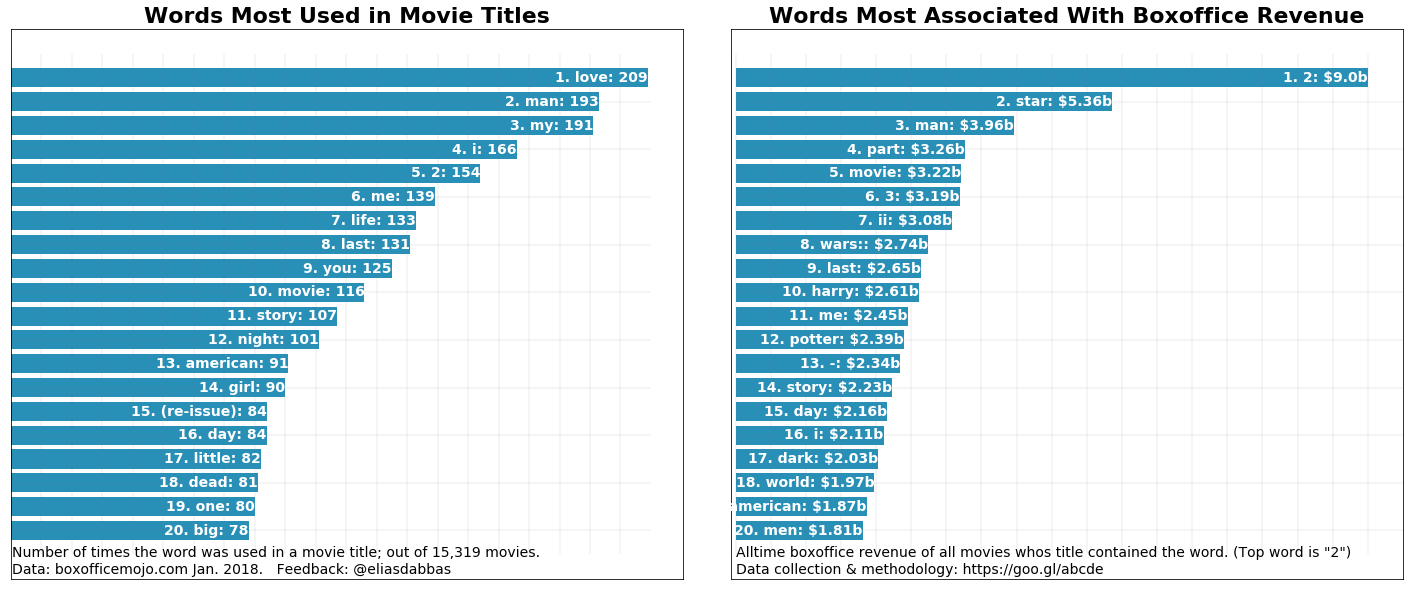

In [8]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)

word_freq_df_abs = word_freq_df.sort_values('abs_freq', ascending=False).reset_index()

plt.barh(range(20),
         list(reversed(word_freq_df_abs['abs_freq'][:20])), color='#288FB7')
for i, word in enumerate(word_freq_df_abs['word'][:20]):
    plt.text(word_freq_df_abs['abs_freq'][i], 20-i-1, 
             s=str(i+1) + '. ' + word + ': '  + str(word_freq_df_abs['abs_freq'][i]),
             ha='right', va='center', fontsize=14, color='white', fontweight='bold')
plt.text(0.4, -1.1, s='Number of times the word was used in a movie title; out of 15,319 movies.', fontsize=14)
plt.text(0.4, -1.8, s='Data: boxofficemojo.com Jan. 2018.   Feedback: @eliasdabbas', fontsize=14)


plt.vlines(range(0, 210, 10), -1, 20, colors='gray', alpha=0.1)
plt.hlines(range(0, 20, 2), 0, 210, colors='gray', alpha=0.1)
plt.yticks([])
plt.xticks([])
plt.title('Words Most Used in Movie Titles', fontsize=22, fontweight='bold')

# =============
plt.subplot(1, 2, 2)
# plt.axis('off')
plt.barh(range(20),
         list(reversed(word_freq_df['wtd_freq'][:20])), color='#288FB7')
for i, word in enumerate(word_freq_df['word'][:20]):
    plt.text(word_freq_df['wtd_freq'][i], 20-i-1, 
             s=str(i+1) + '. ' + word + ': ' + '$' + str(round(word_freq_df['wtd_freq'][i] / 1000_000_000, 2)) + 'b',
             ha='right', va='center', fontsize=14, color='white', fontweight='bold')
plt.text(0.4, -1.1, s='Alltime boxoffice revenue of all movies whos title contained the word. (Top word is "2") ', fontsize=14)
plt.text(0.4, -1.8, s='Data collection & methodology: https://goo.gl/abcde', fontsize=14)

plt.vlines(range(0, 9_500_000_000, 500_000_000), -1, 20, colors='gray', alpha=0.1)
plt.hlines(range(0, 20, 2), 0, 10_000_000_000, colors='gray', alpha=0.1)
plt.xlim((-70_000_000, 9_500_000_000))
plt.yticks([])
plt.xticks([])
plt.title('Words Most Associated With Boxoffice Revenue', fontsize=22, fontweight='bold')
plt.tight_layout(pad=0.01)
plt.show()


Well, it seems that in the minds of producers and writers at least, love does concquer all! It is the most used word in all of the movie titles. It is not that high when it comes to weighted frequency (boxoffice revenue) though. 

In other words, if you look at all the titles of movies, the word 'love' would be the one you would most find. But estimating which word appeared the most in the eyes of the viewers (using gross revenue as a metric), then '2', 'star', and 'man' would be the most viewed, or associated with the most revenue.

Just to be clear, these are very simple calculations, when we say that the weighted frequency of the word 'love' is  1,604,106,767, it simply means that the sum of the lifetime gross of all movies who's title included the word 'love' was that amount. 


It's also interesting that '2' is the top word. Obviously, it is not a word, but it's an indication that the second parts of movie series amount to a very large sum. So is '3', which is in the fifth position. Note that 'part' and 'ii' are also in the top ten, confirmting the same fact. 
 
'American', and 'movie', have very high relative value. 



**A quick note on the stop words used in this function**

Usually you would supply a more comprehensive list of stop words than the one here, especially if you are dealing with articles, or social media posts. For example the `nltk` package provides lists of stop words in several languages, and these can be downloaded and used.  
The words here were chosen after a few checks on the top movies. Many of these are usually considered stop words, but in the case of movie titles, it made sense to keep some of them as they might give some insight. For example, the words 'I', 'me', 'you' might hint at some social dynamics. Another reason is that movie titles are very short phrases, and we are trying to make as much sense as we can from them.
You can definitely try it with your own set of words, and see slightly different results. 

Looking back at the original list of movie titles, we see that some of the top words don't even appear in the top ten, and this is exactly the kind of insight that we are  trying to uncover by using this approach. 


In [19]:
boxoffice_df.head(10)

,lifetime_gross,rank,studio,title,year
0,936662225,1,BV,Star Wars: The Force Awakens,2015
1,760507625,2,Fox,Avatar,2009
2,659363944,3,Par.,Titanic,1997
3,652270625,4,Uni.,Jurassic World,2015
4,623357910,5,BV,Marvel's The Avengers,2012
5,610725821,6,BV,Star Wars: The Last Jedi,2017
6,534858444,7,WB,The Dark Knight,2008
7,532177324,8,BV,Rogue One: A Star Wars Story,2016
8,504014165,9,BV,Beauty and the Beast (2017),2017
9,486295561,10,BV,Finding Dory,2016


Next, I think it would make sense to further explore the top words that are interesting. Let's filter the movies that contain '2' and see: 

In [20]:
(boxoffice_df[boxoffice_df['title']                  
              .str
              .contains('2 | 2', case=False)] # spaces used to exclude words like '2010'
              .head(10)) 

,lifetime_gross,rank,studio,title,year
14,441226247,15,DW,Shrek 2,2004
28,389813101,29,BV,Guardians of the Galaxy Vol. 2,2017
29,381011219,30,WB,Harry Potter and the Deathly Hallows Part 2,2011
33,373585825,34,Sony,Spider-Man 2,2004
36,368061265,37,Uni.,Despicable Me 2,2013
63,312433331,64,Par.,Iron Man 2,2010
78,292324737,79,LG/S,The Twilight Saga: Breaking Dawn Part 2,2012
86,281723902,87,LGF,The Hunger Games: Mockingjay - Part 2,2015
116,245852179,117,BV,Toy Story 2,1999
145,226164286,146,NL,Rush Hour 2,2001


Top 'star' movies

In [21]:
boxoffice_df[boxoffice_df['title'].str.contains('star | star', case=False)].head(10)

,lifetime_gross,rank,studio,title,year
0,936662225,1,BV,Star Wars: The Force Awakens,2015
5,610725821,6,BV,Star Wars: The Last Jedi,2017
7,532177324,8,BV,Rogue One: A Star Wars Story,2016
10,474544677,11,Fox,Star Wars: Episode I - The Phantom Menace,1999
11,460998007,12,Fox,Star Wars,1977
31,380270577,32,Fox,Star Wars: Episode III - Revenge of the Sith,2005
64,310676740,65,Fox,Star Wars: Episode II - Attack of the Clones,2002
104,257730019,105,Par.,Star Trek,2009
138,228778661,139,Par.,Star Trek Into Darkness,2013
299,158848340,300,Par.,Star Trek Beyond,2016


Top 'man' movies

In [22]:
boxoffice_df[boxoffice_df['title'].str.contains('man | man', case=False)].head(10)

,lifetime_gross,rank,studio,title,year
17,423315812,18,BV,Pirates of the Caribbean: Dead Man's Chest,2006
21,409013994,22,BV,Iron Man 3,2013
33,373585825,34,Sony,Spider-Man 2,2004
47,336530303,48,Sony,Spider-Man 3,2007
52,330360194,53,WB,Batman v Superman: Dawn of Justice,2016
58,318412101,59,Par.,Iron Man,2008
63,312433331,64,Par.,Iron Man 2,2010
81,291045518,82,WB,Man of Steel,2013
174,206852432,175,WB,Batman Begins,2005
180,202853933,181,Sony,The Amazing Spider-Man 2,2014


**Next steps / improvements:**

* Get more words: movie titles are extremely short and many times don't convey the literal meaning of the words. For example, a godfather is supposed to be a person who whitnesses a child's christening, and promises to take care of that child (or maybe a mafioso who kills for pleasure?!).  
A further exercise might be to get more detailed descriptions, in addition to the movie title. For example: 

> "A computer hacker learns from mysterious rebels about the true nature of his reality and his role in the war against its controllers."  

tells us much more about the movie, than 'The Matrix'.

* Better statistical analysis: handling extreme values / outliers, using other metrics. 
* Text mining: grouping similar words and topics together ('happy', 'happiness', 'happily', etc.)
* Granlular analysis: running the same function for different years / decades, or for certain production studios. 

You might be interested in exploring the data yourself as well as other data: 

* [Boxoffice data](data/boxoffice.csv)
* [Gutenberg top 1,000 downloaded books](data/gutenberg.csv)
    - Which words are the most used in book titles? 
    - Which words are the most associated with book downloads? 
* [iPhone search keywords](data/iphone.csv) (obtained through [SERPs](https://serps.com/tools/keyword-research/))
    - What do people search for together with 'iphone'? 
    - What has the most weighted frequency? 

It might be easier to just [clone the repository](https://github.com/eliasdabbas/word_frequency) with the code and try for yourself.


The `word_frequency` function is part of the [advertools](https://github.com/eliasdabbas/advertools) package, which you can download and try using in your work / research. 



Check it out and let me know! [@eliasdabbas](https://twitter.com/eliasdabbas)